In [1]:
import torch, random, math, time, sys, os, tqdm
import numpy as np
import numba
import importlib
import models.sparse_token as sparse
importlib.reload(sparse)

/home/ainl/anaconda3/envs/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'models.sparse_token' from '/home/ainl/library/discrete_edge_learning/models/sparse_token.py'>

In [2]:
from trainer.classification import Trainer
from trainer.attention_approx import Trainer as ApproxTrainer
batch_size = 4
device = 0
factor = 16

trainer = Trainer(batch_size=batch_size, model='bert-base', device=device)
trainer.load()
trainer.model.eval()
bert = trainer.model.bert
fc = trainer.model.classifier
batch = trainer.get_batch()
test_batch = trainer.get_batch(test=False)

approx_trainer = ApproxTrainer(batch_size=batch_size, factor=factor, model=trainer.model_type, device=trainer.device)
approx_trainer.load()
approx_bert = approx_trainer.bert
approx_bert = approx_bert.eval()
print('approx trained', approx_trainer.steps)

100%|██████████| 120000/120000 [00:00<00:00, 398319.47it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000


100%|██████████| 7600/7600 [00:00<00:00, 381784.44it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-base
Trainer.load: Loading... saves/cls_bert-base.pth


100%|██████████| 120000/120000 [00:00<00:00, 388140.76it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:1012, avg_len:236.477525, count:120000


100%|██████████| 7600/7600 [00:00<00:00, 390249.02it/s]


Classification Dataset Stat.: name:AG_NEWS, nclass:5, max_len:892, avg_len:235.2992105263158, count:7600


Some weights of the model checkpoint at google/bert_uncased_L-12_H-768_A-12 were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Trainer.__init__: Model initialized. model = bert-base
Trainer.load: Loading... saves/cls_bert-base.pth
Trainer.load: saves/att_approx_16_bert-base.pth
approx trained 150000


In [3]:
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())

<All keys matched successfully>

In [55]:
importlib.reload(sparse)
sparse.benchmark_reset()
sparse.timer_reset()

def eval_fc(lm_output, fc=fc, batch=batch):
    last_hidden = lm_output.last_hidden_state[:,0,:]
    x = fc(last_hidden)
    return torch.argmax(x, dim=-1), batch.labels, lm_output

def eval(bert, fc=fc, batch=batch):
    lm_output = bert(
        input_ids = batch.input_ids, 
        attention_mask = batch.attention_masks,
        output_hidden_states = True,
        output_attentions = True,
    )
    return eval_fc(lm_output, fc=fc, batch=batch)

def approx_eval(sparse_bert, approx_bert, fc=fc, batch=batch, k=0.5):
    lm_output = sparse.run_bert_with_approx(
        sparse_bert, 
        approx_bert, 
        {
            'input_ids': batch.input_ids,
            'attention_mask': batch.attention_masks,
            'output_hidden_states': True,
            'output_attentions': True,
        },
        ks = [k]*(len(sparse_bert.encoder.layer)),
    )
    return eval_fc(lm_output, fc=fc, batch=batch)

def forward_eval(sparse_bert, fc=fc, batch=batch, k=0.5):
    lm_output = sparse.run_bert_forward_sparsity(
        sparse_bert, 
        {
            'input_ids': batch.input_ids,
            'attention_mask': batch.attention_masks,
            'output_hidden_states': True,
            'output_attentions': True,
        },
        ks = k,
    )
    return eval_fc(lm_output, fc=fc, batch=batch)

eval(bert)[:2], forward_eval(sparse_bert)[:2]

((tensor([1, 2, 4, 1], device='cuda:0'),
  tensor([1, 2, 4, 1], device='cuda:0')),
 (tensor([1, 2, 4, 1], device='cuda:0'),
  tensor([1, 2, 4, 1], device='cuda:0')))

In [56]:
lm_output = sparse.run_bert_forward_sparsity(
    sparse_bert, 
    {
        'input_ids': batch.input_ids,
        'attention_mask': batch.attention_masks,
        'output_hidden_states': True,
        'output_attentions': True,
    },
    ks = 0.5,
)
lm_output.attentions[0][0,0]

tensor([[0.2871, 0.1998, 0.0007,  ..., 0.0000, 0.0000, 0.0000],
        [0.2825, 0.2313, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0885, 0.0806, 0.0056,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.5495, 0.2041, 0.0011,  ..., 0.0000, 0.0000, 0.0000],
        [0.5037, 0.2072, 0.0011,  ..., 0.0000, 0.0000, 0.0000],
        [0.4037, 0.2040, 0.0038,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [53]:
importlib.reload(sparse)
sparse.benchmark_reset()
sparse.timer_reset()

#7600 is original
def accuracy(batch_eval, N=600//4, return_lm=False):
    #N = 10
    trainer.seed()
    trainer.dataset.batch_size = 4
    acc_sum = 0
    for i in tqdm.tqdm(range(N)):
        batch = trainer.get_batch(test=True)
        with torch.no_grad():
            output, label, _ = batch_eval(batch)
        acc_sum += torch.mean((output == label) * 1.0)
    if return_lm: return acc_sum.item() / N, _
    return acc_sum.item() / N

# setup for evaluation
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse_bert = sparse_bert.to(trainer.device)
approx_bert = approx_bert.to(trainer.device)
bert = bert.to(trainer.device)
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse.timer_reset()
k = 0.25
acc, lm = accuracy(
    lambda batch: approx_eval(sparse_bert, bert, batch=batch, k=k),
    return_lm = True,
)
acc_, lm = accuracy(
    lambda batch: forward_eval(sparse_bert, batch=batch, k=k),
    return_lm = True,
)
#acc = accuracy(lambda batch: eval(bert, batch=batch))
# sparse.timer_report()
# sparse.benchmark_report()
acc_, acc

 83%|████████▎ | 124/150 [00:02<00:00, 43.67it/s]


KeyboardInterrupt: 

In [23]:
#0.15 79         45.5
#0.25 86.69      80.6184
#0.5  91.4736    91.802     0.5:0.91842 0.2:0.91855 0.1:0.9186 0:0.9180

100%|██████████| 150/150 [00:21<00:00,  6.93it/s]


0.1 0.5203836930455636 0.3616666666666667 0.695


100%|██████████| 150/150 [00:21<00:00,  6.90it/s]


0.25 0.9214145383104124 0.7816666666666666 0.8483333333333334


100%|██████████| 150/150 [00:21<00:00,  6.89it/s]


0.375 0.9816513761467891 0.8916666666666667 0.9083333333333333


100%|██████████| 150/150 [00:21<00:00,  6.89it/s]


0.5 1.0018281535648994 0.9133333333333333 0.9116666666666666


100%|██████████| 150/150 [00:22<00:00,  6.79it/s]

0.75 1.0072332730560578 0.9283333333333333 0.9216666666666666


<AxesSubplot:>

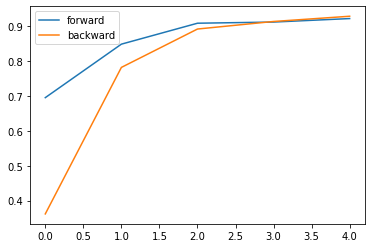

In [58]:
importlib.reload(sparse)
sparse.benchmark_reset()
sparse.timer_reset()

# setup for evaluation
sparse_bert = sparse.SparseBertModel(bert.config)
sparse_bert.to(trainer.device)
sparse_bert.eval()
sparse_bert.load_state_dict(bert.state_dict())
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

sparse_bert = sparse_bert.to(trainer.device)
approx_bert = approx_bert.to(trainer.device)
bert = bert.to(trainer.device)
sparse.set_print(sparse_bert, False)
sparse.set_backup_last_inputs(sparse_bert, False)
sparse.set_output_masking(sparse_bert, False)

acc_bert = accuracy(lambda batch: eval(bert, batch=batch))
accs_backward = []
accs_forward = []
ks = [0.1, 0.25, 0.375, 0.5, 0.75]
for k in ks:
    acc_backward=acc_forward = 1.0
    acc_backward, lm = accuracy(
        lambda batch: approx_eval(sparse_bert, approx_bert, batch=batch, k=k),
        return_lm = True,
    )
    acc_forward, lm = accuracy(
        lambda batch: forward_eval(sparse_bert, batch=batch, k=k),
        return_lm = True,
    )
    accs_backward.append(acc_backward)
    accs_forward.append(acc_forward)
    print(k, acc_backward / acc_forward, acc_backward, acc_forward)

import pandas as pd
df = pd.DataFrame()
df['forward'] = accs_forward
df['backward'] = accs_backward
df.plot()

In [ ]:
df #forward

In [50]:
df #not adjust

,forward,backward
0,1.0,0.360000
1,1.0,0.831447
2,1.0,0.900921
3,1.0,0.917895
4,1.0,0.926053


In [48]:
df #adjust softmax

,forward,backward
0,1.0,0.301842
1,1.0,0.665132
2,1.0,0.837105
3,1.0,0.902500
4,1.0,0.925789


In [ ]:
lm_output = sparse.run_bert_with_approx(
    sparse_bert, 
    approx_bert, 
    {
        'input_ids': batch.input_ids,
        'attention_mask': batch.attention_masks,
        'output_hidden_states': True,
        'output_attentions': True,
    },
    ks = [0.999]+[k]*(len(sparse_bert.encoder.layer)-1),
)

lm_output = sparse.run_bert_forward_sparsity(
    sparse_bert, 
    {
        'input_ids': batch.input_ids,
        'attention_mask': batch.attention_masks,
        'output_hidden_states': True,
        'output_attentions': True,
    },
    ks = k,
)